In [8]:
from tqdm.auto import tqdm # A simple loading bar
import matplotlib.pyplot as plt # A standard plotting library
import pandas as pd
import numpy as np
from multiprocessing import cpu_count
from cache_decorator import Cache
from glob import glob 
import seaborn as sns
from keras_bed_sequence import BedSequence



C:\Users\matte\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\matte\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\matte\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\matte\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
cell_line1 = "HepG2"
cell_line = "HEK293"
assembly = "hg19"
window_size = 200



In [3]:
from epigenomic_dataset import load_epigenomes


promoters_epigenomes, promoters_labels = load_epigenomes(
    cell_line = cell_line,
    dataset = "fantom",
    regions = "promoters",
    window_size = window_size
)

enhancers_epigenomes, enhancers_labels = load_epigenomes(
    cell_line = cell_line,
    dataset = "fantom",
    regions = "enhancers",
    window_size = window_size
)

promoters_epigenomes = promoters_epigenomes.droplevel(1, axis=1) 
enhancers_epigenomes = enhancers_epigenomes.droplevel(1, axis=1) 

In [4]:
epigenomes = {
    "promoters": promoters_epigenomes,
    "enhancers": enhancers_epigenomes
}

labels = {
    "promoters": promoters_labels,
    "enhancers": enhancers_labels
}

In [5]:
from ucsc_genomes_downloader import Genome

genome = Genome(assembly)

In [6]:
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]


def one_hot_encode(genome:Genome, data:pd.DataFrame, nucleotides:str="actg")->np.ndarray:
    return np.array(BedSequence(
        genome,
        bed=to_bed(data),
        nucleotides=nucleotides,
        batch_size=1
    ))

def flat_one_hot_encode(genome:Genome, data:pd.DataFrame, window_size:int, nucleotides:str="actg")->np.ndarray:
    return one_hot_encode(genome, data, nucleotides).reshape(-1, window_size*4).astype(int)

def to_dataframe(x:np.ndarray, window_size:int, nucleotides:str="actg")->pd.DataFrame:
    return pd.DataFrame(
        x,
        columns = [
            f"{i}{nucleotide}"
            for i in range(window_size)
            for nucleotide in nucleotides
        ]
    )

In [10]:
sequences = {
    region: to_dataframe(
        flat_one_hot_encode(genome, data, window_size),
        window_size
    )
    for region, data in epigenomes.items()
}

In [13]:
sequences


{'promoters':        0a  0c  0t  0g  1a  1c  1t  1g  2a  2c  ...  197t  197g  198a  198c  \
 0       1   0   0   0   1   0   0   0   0   1  ...     0     1     0     1   
 1       0   1   0   0   0   1   0   0   0   1  ...     0     0     0     1   
 2       1   0   0   0   0   0   0   1   0   0  ...     0     0     0     0   
 3       0   0   1   0   0   0   0   1   0   0  ...     0     0     0     0   
 4       0   0   0   1   0   0   0   1   0   0  ...     0     1     0     0   
 ...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   ...   ...   ...   ...   
 99904   0   0   0   1   0   0   0   1   0   1  ...     0     0     0     0   
 99905   0   0   0   1   0   0   0   1   0   0  ...     0     0     0     1   
 99906   0   0   0   1   0   1   0   0   0   0  ...     1     0     0     1   
 99907   0   1   0   0   0   0   1   0   0   0  ...     0     1     0     1   
 99908   0   1   0   0   0   0   0   1   1   0  ...     0     0     0     1   
 
        198t  198g  199a  199c  199t 

In [14]:
for region, x in epigenomes.items():
    print(
        f"The rate between features and samples for {region} data is: {x.shape[0]/x.shape[1]}"
    )
    print("="*80)

The rate between features and samples for promoters data is: 482.6521739130435
The rate between features and samples for enhancers data is: 316.05314009661834


In [ ]:
for region, x in epigenomes.items():
    print("\n".join((
        f"Nan values report for {region} data:",
        f"In the document there are {x.isna().values.sum()} NaN values out of {x.values.size} values.",
        f"The sample (row) with most values has {x.isna().sum(axis=0).max()} NaN values out of {x.shape[1]} values.",
        f"The feature (column) with most values has {x.isna().sum().max()} NaN values out of {x.shape[0]} values."
    )))
    print("="*80)

In [15]:
from sklearn.impute import KNNImputer

def knn_imputer(df:pd.DataFrame, neighbours:int=5)->pd.DataFrame:
    return pd.DataFrame(
        KNNImputer(n_neighbors=neighbours).fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [16]:
for region, x in epigenomes.items():
    epigenomes[region] = knn_imputer(x)

HEK293    11513
dtype: int64
HEK293    6952
dtype: int64


C:\Users\matte\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


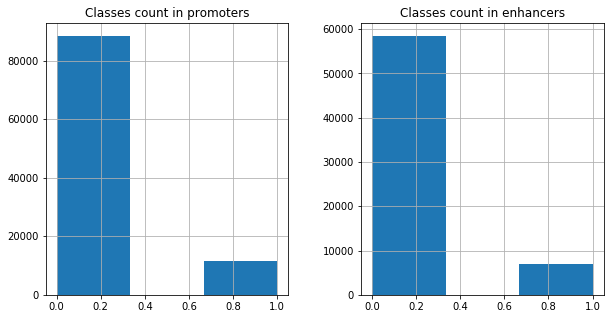

In [26]:

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

for axis, (region, y) in zip(axes.ravel(), labels.items()):
    
    y.hist(ax=axis, bins=3) #bins 3 =le colonne misurano 1/3 del grafico
    axis.set_title(f"Classes count in {region}")
    print(y.sum())
fig.show()

In [27]:
def drop_constant_features(df:pd.DataFrame)->pd.DataFrame:
    """Return DataFrame without constant features."""
    return df.loc[:, (df != df.iloc[0]).any()]

In [28]:
for region, x in epigenomes.items():
    result = drop_constant_features(x)
    if x.shape[1] != result.shape[1]:
        print(f"Features in {region} were constant and had to be dropped!")
        epigenomes[region] = result
    else:
        print(f"No constant features were found in {region}!")

No constant features were found in promoters!
No constant features were found in enhancers!


In [29]:
from sklearn.preprocessing import RobustScaler

def robust_zscoring(df:pd.DataFrame)->pd.DataFrame:
    return pd.DataFrame(
        RobustScaler().fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

# Dictionary comprehension
epigenomes = {
    region: robust_zscoring(x)
    for region, x in epigenomes.items()
}

In [30]:
# Robust normalization step by step
# # 
# feature = epigenomes["promoters"]["PRDM10"]

# feature.hist(bins=100)
# plt.show()

# head, tail = feature.quantile([0.1, 0.9])
# print(head, tail)


# mask = (feature > head) & (feature < tail)
# masked_feature = feature[mask]

# print(feature.min(), feature.max())
# print(feature.mean(), feature.median(), feature.std(), masked_feature.std(), masked_feature.mean())

# masked_feature.hist(bins=30)
# plt.show()

# print(masked_feature.std(), feature.std())

# normalized_feature = (feature - feature.median()) / masked_feature.std()

# normalized_feature.hist(bins=100)
# plt.show()

# fig, axis = plt.subplots(figsize=(10, 5))

# feature.hist(ax=axis, bins=100, alpha=0.8)
# normalized_feature.hist(ax=axis, bins=100, alpha=0.8)
# plt.show() 

KeyError: 'PRDM10'

In [31]:
p_value_threshold = 0.01
correlation_threshold = 0.05 #piccolo perché cerchiamo quelle poco correlate

uncorrelated = {
    region: set()
    for region in epigenomes
}

In [34]:
from scipy.stats import pearsonr

for region, x in epigenomes.items():
    #print(region,x.columns)
    for column in tqdm(x.columns, desc=f"Running Pearson test for {region}", dynamic_ncols=True, leave=False):
        correlation, p_value = pearsonr(x[column].values.ravel(), labels[region].values.ravel())
        if p_value > p_value_threshold:
            
            print(region, column, correlation)
            uncorrelated[region].add(column)

promoters ZNF133 -0.0013852132233854557
promoters ZNF549 -0.0007039520811079388
promoters GLI2 0.007884451497978711
promoters ZNF350 0.005185227592625774
promoters eGFP-ZNF768 0.008008837702244288
promoters eGFP-ZNF777 0.0029822159227827208
promoters eGFP-ZNF645 -0.004271610091438015
promoters eGFP-ZNF585B 0.0046592792020883666
promoters eGFP-RBAK -0.007116158251110531


enhancers ZNF266 0.008938329948253845
enhancers SALL1 0.008277975163893819
enhancers ZNF404 0.004224085952601985
enhancers ZNF549 -0.000878862646484399
enhancers ZNF19 0.0041322822277791585
enhancers ZNF169 -0.001644812229583399
enhancers eGFP-PRDM2 0.0016765154039004842
enhancers eGFP-ZNF768 0.007832080265030551
enhancers eGFP-ZNF426 -0.00020092427556283178
enhancers eGFP-ZNF214 0.008510657744898512
enhancers eGFP-ZNF23 0.0016668930508557923
enhancers eGFP-ZNF548 0.007184919518446558
enhancers eGFP-ZNF624 0.008596082071654732
enhancers eGFP-ZNF585B 0.008449669232017596
enhancers eGFP-ZNF701 0.00889399546927365
enhancers eGFP-ZNF138 0.007136482971631454
enhancers eGFP-ZNF157 0.007878145178499031
enhancers eGFP-ZNF677 0.004502716843512603
enhancers eGFP-ZNF155 0.0033213614559867597
enhancers eGFP-ZNF331 0.0026682902370178917
enhancers eGFP-ZNF791 0.003974900351718942
enhancers eGFP-ZNF491 -0.004060712578466641
enhancers eGFP-ZNF211 -0.008220075274244476
enhancers eGFP-ZBTB49 -0.00761860

In [35]:
from scipy.stats import spearmanr

for region, x in epigenomes.items():
    for column in tqdm(x.columns, desc=f"Running Spearman test for {region}", dynamic_ncols=True, leave=False):
        correlation, p_value = spearmanr(x[column].values.ravel(), labels[region].values.ravel())
        if p_value > p_value_threshold:
            print(region, column, correlation)
            uncorrelated[region].add(column)

promoters ZNF223 -0.0006175508610789729
promoters GLI2 0.0005013835055510463
promoters eGFP-ZNF768 -0.006237213400860507
promoters eGFP-AEBP2 0.006049476408416468
promoters eGFP-ZNF585B -0.005192522362945487
promoters eGFP-ZNF302 0.004404776298511936


enhancers SALL1 0.007214240020413349
enhancers ZNF404 0.003936590581658297
enhancers ZNF549 -0.007204338956519297
enhancers ZNF19 0.005538532188567959
enhancers ZNF169 -0.005577163218517683
enhancers BCL6B -0.0001707606172981321
enhancers eGFP-PRDM2 0.0004575469714260818
enhancers eGFP-ZNF768 0.004474412261550041
enhancers eGFP-ZNF777 0.0050496127004586834
enhancers eGFP-ZNF426 -0.0037392775200136936
enhancers eGFP-ZNF214 0.00688870913236058
enhancers eGFP-ZNF23 0.00027194873201684313
enhancers eGFP-ZNF548 0.005920540525224045
enhancers eGFP-ZNF624 0.00884114682740176
enhancers eGFP-ZNF585B 0.006882899358013972
enhancers eGFP-ZNF701 0.006256132443061694
enhancers eGFP-ZNF680 0.00871089558762441
enhancers eGFP-ZNF138 0.009307679185999191
enhancers eGFP-ZNF157 0.006314072562372218
enhancers eGFP-ZNF155 0.0013979937007266375
enhancers eGFP-ZNF626 0.009733791917186966
enhancers eGFP-ZNF331 0.001365580356999735
enhancers eGFP-ZNF791 0.0025492577848601912
enhancers eGFP-ZNF491 -0.00413193057

In [ ]:
from minepy import MINE

for region, x in epigenomes.items():
    for column in tqdm(uncorrelated[region], desc=f"Running MINE test for {region}", dynamic_ncols=True, leave=False):
        mine = MINE()
        mine.compute_score(x[column].values.ravel(), labels[region].values.ravel())
        score = mine.mic()
        if score < correlation_threshold:
            print(region, column, score)
        else:
            uncorrelated[region].remove(column)

In [37]:
print(len(uncorrelated['promoters']),len(uncorrelated['enhancers']))

12 32


In [38]:
p_value_threshold = 0.01
correlation_threshold = 0.95 #grande perché cerchiamo quelle molto correlate

from scipy.stats import spearmanr
from scipy.stats import entropy

extremely_correlated = {
    region: set()
    for region in epigenomes
}

scores = {
    region: []
    for region in epigenomes
}

for region, x in epigenomes.items():
    for i, column in tqdm(
        enumerate(x.columns),
        total=len(x.columns), desc=f"Running Pearson test for {region}", dynamic_ncols=True, leave=False):
        for feature in x.columns[i+1:]:
            correlation, p_value = pearsonr(x[column].values.ravel(), x[feature].values.ravel())
            correlation = np.abs(correlation)
            scores[region].append((correlation, column, feature))
            if p_value < p_value_threshold and correlation > correlation_threshold:
                print(region, column, feature, correlation)
                if entropy(x[column]) > entropy(x[feature]):
                    extremely_correlated[region].add(feature)
                else:
                    extremely_correlated[region].add(column)

In [39]:
extremely_correlated

{'promoters': set(), 'enhancers': set()}

In [40]:
scores = {
    region:sorted(score, key=lambda x: np.abs(x[0]), reverse=True)
    for region, score in scores.items()
}

Most correlated features from promoters epigenomes


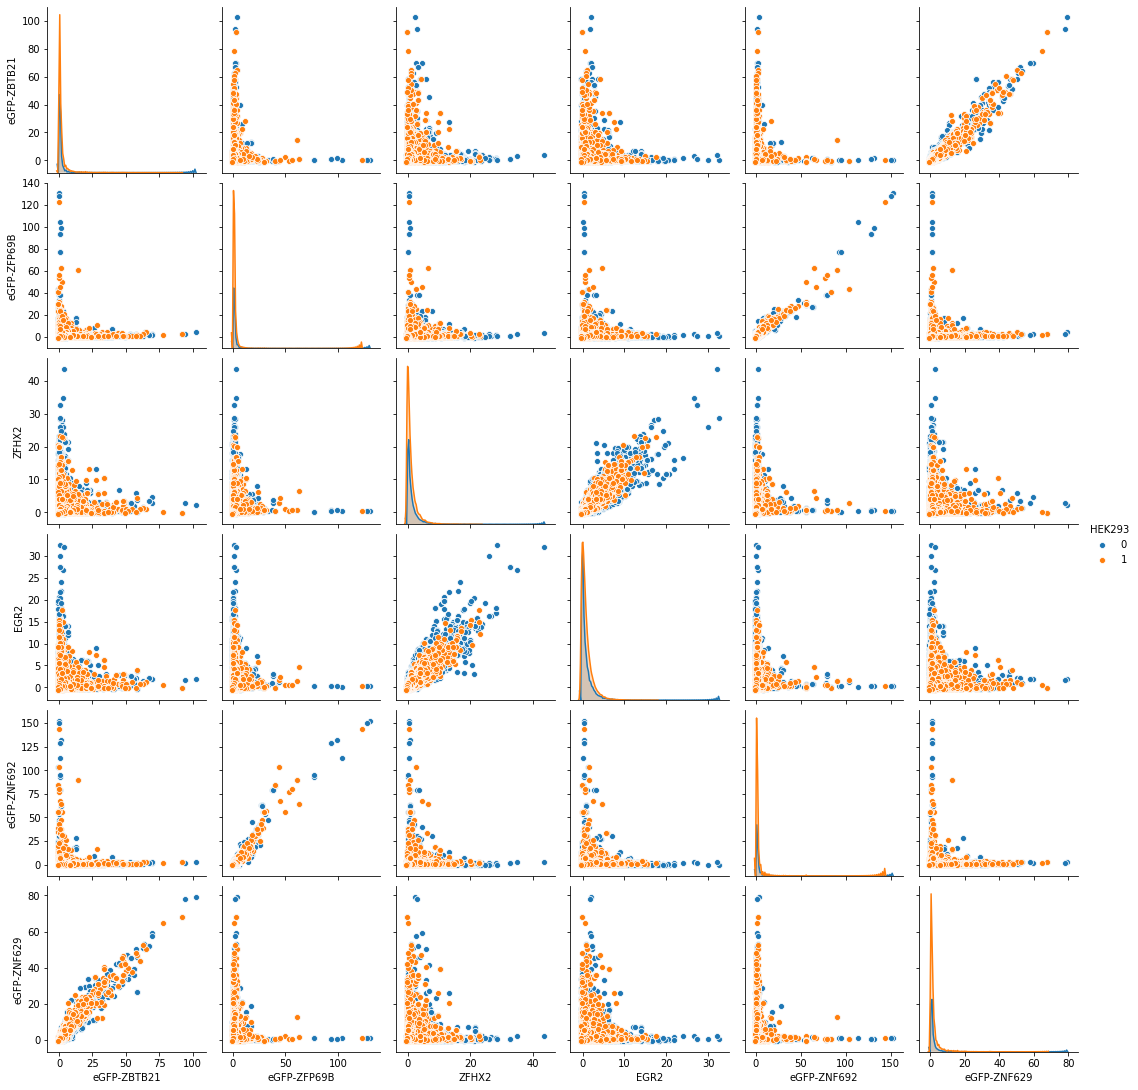

Most correlated features from enhancers epigenomes


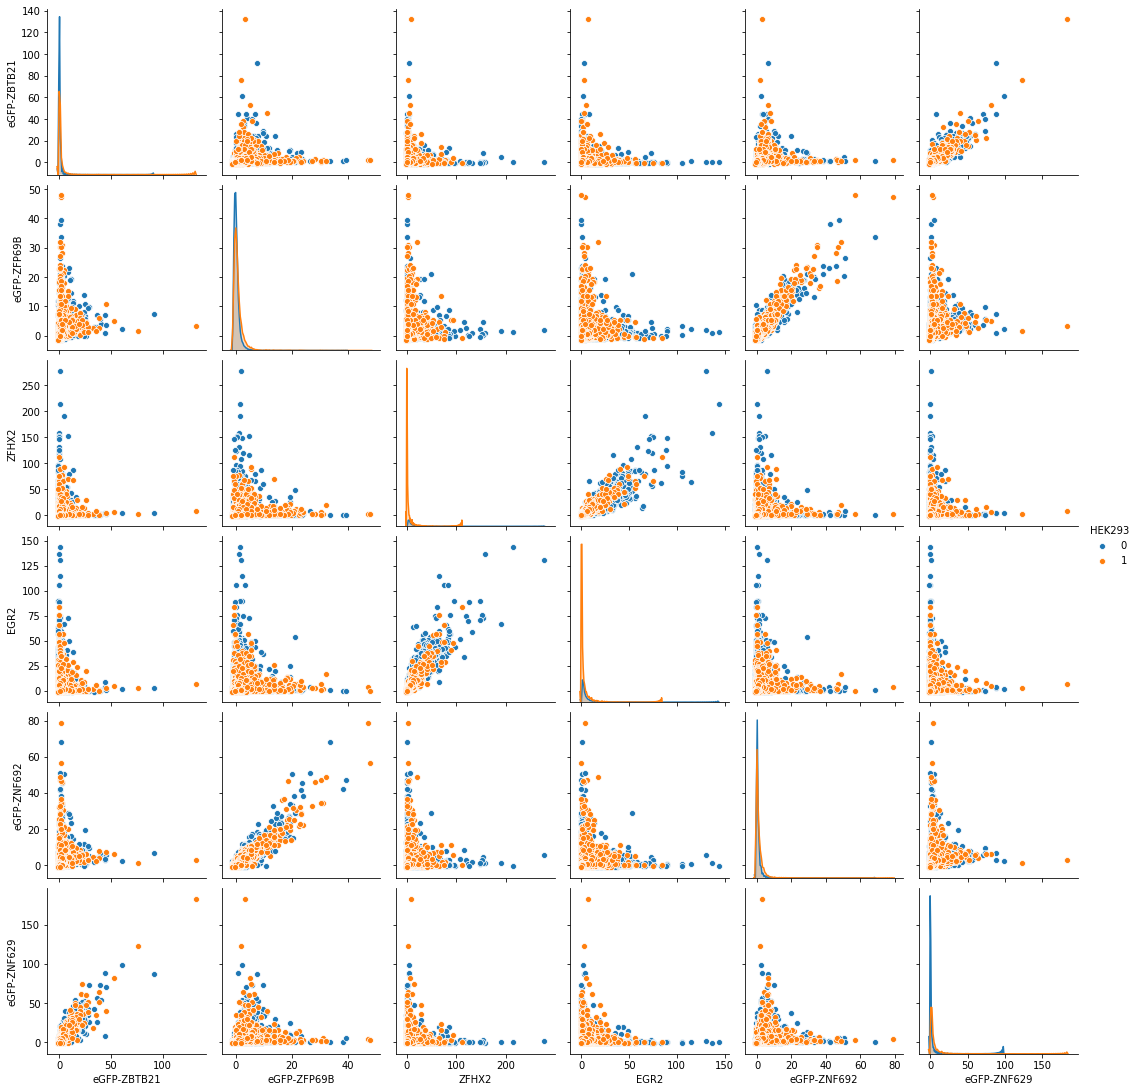

In [41]:
for region, x in epigenomes.items():
    _, firsts, seconds = list(zip(*scores[region][:3]))
    columns = list(set(firsts+seconds))
    print(f"Most correlated features from {region} epigenomes")
    sns.pairplot(pd.concat([
        x[columns],
        labels[region],
    ], axis=1), hue=labels[region].columns[0])
    plt.show()

Least correlated features from promoters epigenomes


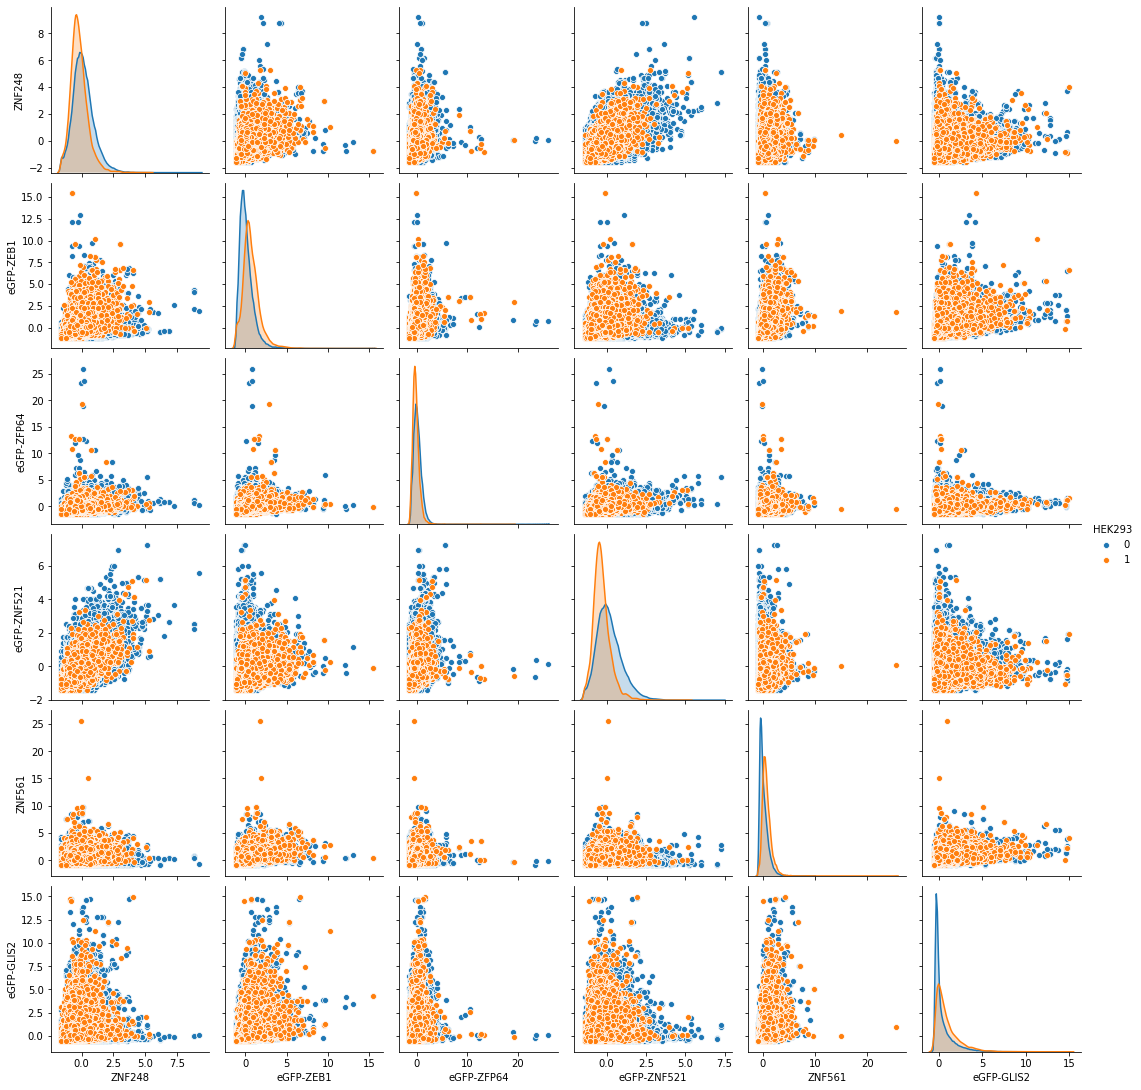

Least correlated features from enhancers epigenomes


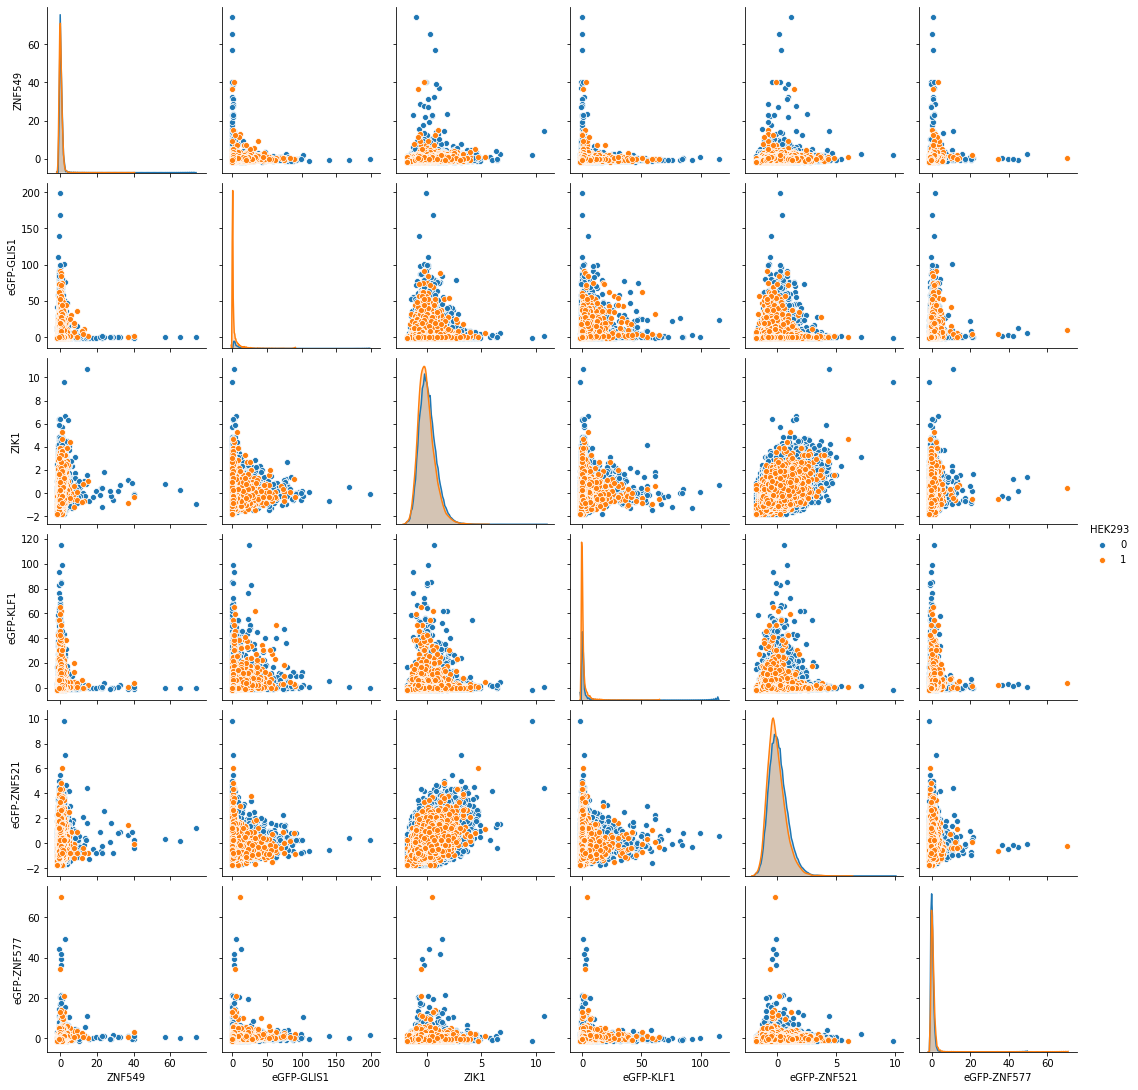

In [42]:
for region, x in epigenomes.items():
    _, firsts, seconds = list(zip(*scores[region][-3:]))
    columns = list(set(firsts+seconds))
    print(f"Least correlated features from {region} epigenomes")
    sns.pairplot(pd.concat([
        x[columns],
        labels[region],
    ], axis=1), hue=labels[region].columns[0])
    plt.show()

In [43]:
from sklearn.metrics.pairwise import euclidean_distances
def get_top_most_different(dist, n:int):
    return np.argsort(-np.mean(dist, axis=1).flatten())[:n]

Top 5 different features from promoters.


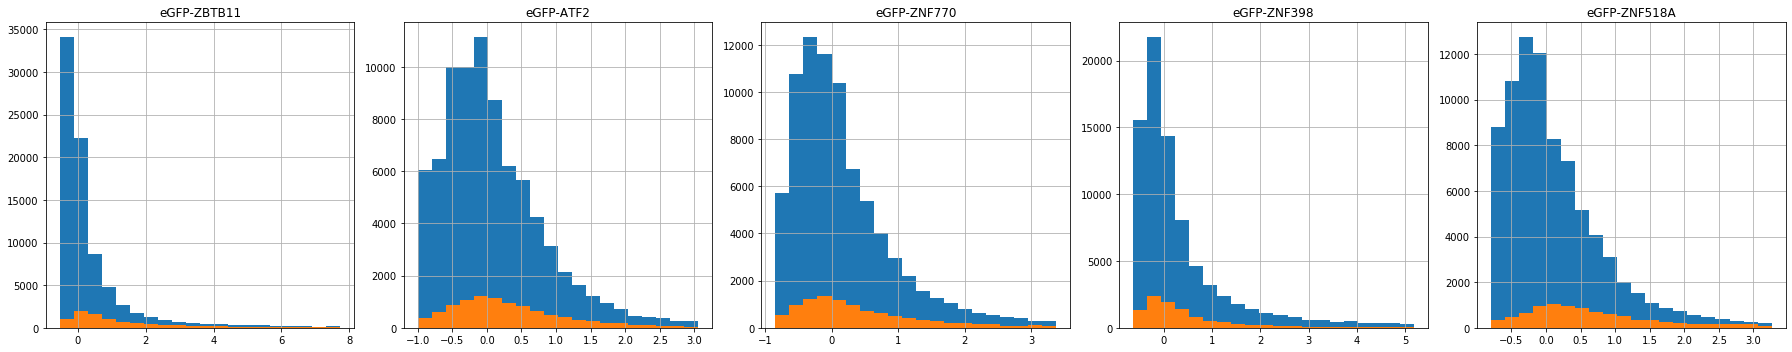

Top 5 different features from enhancers.


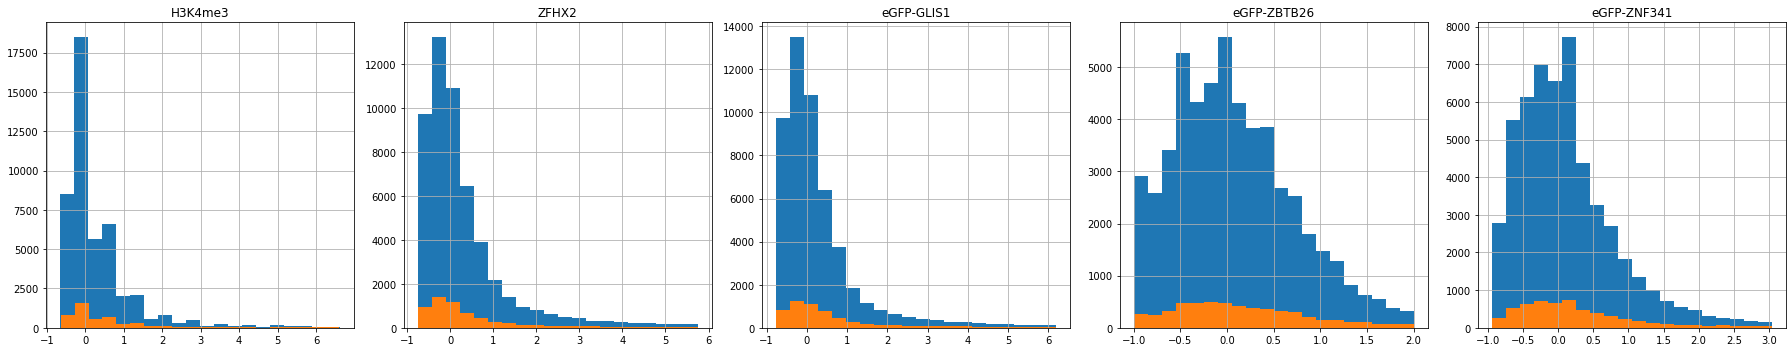

In [44]:
top_number = 5

for region, x in epigenomes.items():
    dist = euclidean_distances(x.T)
    most_distance_columns_indices = get_top_most_different(dist, top_number)
    columns = x.columns[most_distance_columns_indices]
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
    print(f"Top {top_number} different features from {region}.")
    for column, axis in zip(columns, axes.flatten()):
        head, tail = x[column].quantile([0.05, 0.95]).values.ravel()
        
        mask = ((x[column] < tail) & (x[column] > head)).values
        
        cleared_x = x[column][mask]
        cleared_y = labels[region].values.ravel()[mask]
        
        cleared_x[cleared_y==0].hist(ax=axis, bins=20)
        cleared_x[cleared_y==1].hist(ax=axis, bins=20)

        axis.set_title(column)
    fig.tight_layout()
    plt.show()

In [45]:
def get_top_most_different_tuples(dist, n:int):
    return list(zip(*np.unravel_index(np.argsort(-dist.ravel()), dist.shape)))[:n]

Top 5 different tuples of features from promoters.


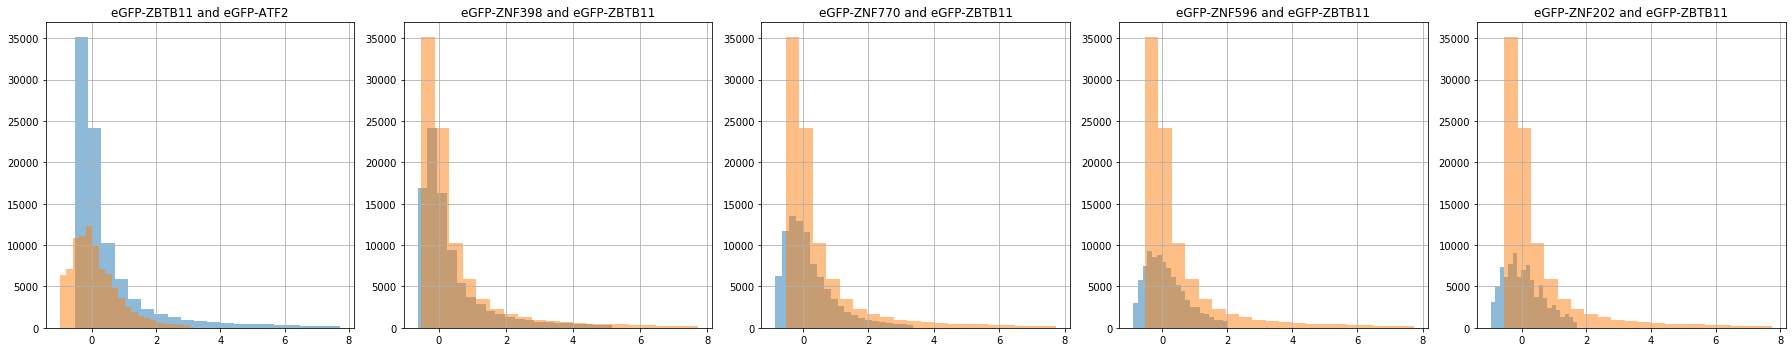

Top 5 different tuples of features from enhancers.


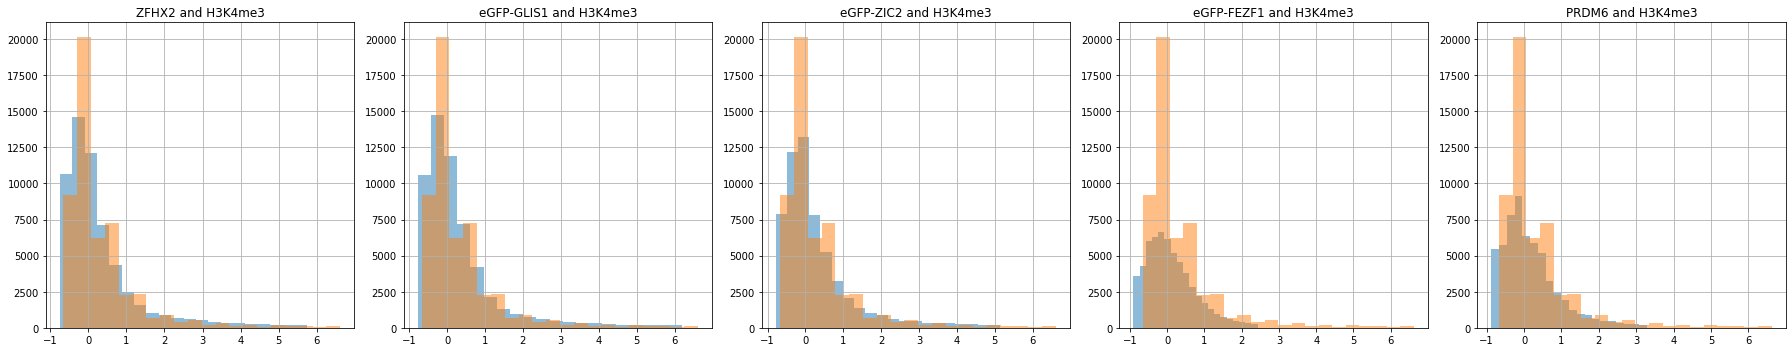

In [46]:
top_number = 5

for region, x in epigenomes.items():
    dist = euclidean_distances(x.T)
    dist = np.triu(dist)
    tuples = get_top_most_different_tuples(dist, top_number)
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
    print(f"Top {top_number} different tuples of features from {region}.")
    for (i, j), axis in zip(tuples, axes.flatten()):
        column_i = x.columns[i]
        column_j = x.columns[j]
        for column in (column_i, column_j):
            head, tail = x[column].quantile([0.05, 0.95]).values.ravel()
            mask = ((x[column] < tail) & (x[column] > head)).values
            x[column][mask].hist(ax=axis, bins=20, alpha=0.5)
        axis.set_title(f"{column_i} and {column_j}")
    fig.tight_layout()
    plt.show()

In [47]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

def get_features_filter(X:pd.DataFrame, y:pd.DataFrame, name:str)->BorutaPy:
    boruta_selector = BorutaPy(
        RandomForestClassifier(n_jobs=cpu_count(), class_weight='balanced', max_depth=5),
        n_estimators='auto',
        verbose=2,
        alpha=0.05, # p_value
        max_iter=10, # In practice one would run at least 100-200 times
        random_state=42
    )
    boruta_selector.fit(X.values, y.values.ravel())
    return boruta_selector

filtered_epigenomes = {
    region:get_features_filter(
        X=x,
        y=labels[region],
        name=f"{cell_line}/{region}"
    ).transform(x.values)
    for region, x in tqdm(
        epigenomes.items(),
        desc="Running Baruta Feature estimation"
    )
}

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	207
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	207
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	207
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	207
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	207
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	207
Rejected: 	0
Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	207
Rejected: 	0
Iteration: 	8 / 10
Confirmed: 	186
Tentative: 	21
Rejected: 	0
Iteration: 	9 / 10
Confirmed: 	186
Tentative: 	21
Rejected: 	0


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	186
Tentative: 	15
Rejected: 	0
Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	207
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	207
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	207
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	207
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	207
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Ten

In [48]:
from sklearn.decomposition import PCA

def pca(x:np.ndarray, n_components:int=2)->np.ndarray:
    return PCA(n_components=n_components, random_state=42).fit_transform(x)

In [49]:
from prince import MFA

def mfa(x:pd.DataFrame, n_components:int=2, nucleotides:str='actg')->np.ndarray:
    return MFA(groups={
        nucleotide: [
            column
            for column in x.columns
            if nucleotide in column
        ]
        for nucleotide in nucleotides
    }, n_components=n_components, random_state=42).fit_transform(x)

In [50]:
from sklearn.manifold import TSNE as STSNE

def sklearn_tsne(x:np.ndarray, perplexity:int, dimensionality_threshold:int=50):
    if x.shape[1] > dimensionality_threshold:
        x = pca(x, n_components=dimensionality_threshold)
    return STSNE(perplexity=perplexity, n_jobs=cpu_count(), random_state=42).fit_transform(x)

In [51]:
from MulticoreTSNE import MulticoreTSNE as UTSNE

def ulyanov_tsne(x:np.ndarray, perplexity:int, dimensionality_threshold:int=50):
    if x.shape[1] > dimensionality_threshold:
        x = pca(x, n_components=dimensionality_threshold)
    return UTSNE(perplexity=perplexity, n_jobs=cpu_count(), random_state=42).fit_transform(x)

ModuleNotFoundError: No module named 'MulticoreTSNE'

In [ ]:
from tsnecuda import TSNE as CTSNE

def cannylab_tsne(x:np.ndarray, perplexity:int, dimensionality_threshold:int=50):
    if x.shape[1] > dimensionality_threshold:
        x = pca(x, n_components=dimensionality_threshold)
    return CTSNE(perplexity=perplexity, random_seed=42).fit_transform(x)

In [52]:
tasks = {
    "x":[
        *[
            val.values
            for val in epigenomes.values()
        ],
        *[
            val.values
            for val in sequences.values()
        ],
        pd.concat(sequences.values()).values,
        pd.concat(sequences.values()).values,
        *[
            np.hstack([
                pca(epigenomes[region], n_components=25),
                mfa(sequences[region], n_components=25)
            ])
            for region in epigenomes
        ]
    ],
    "y":[
        *[
            val.values.ravel()
            for val in labels.values()
        ],
        *[
            val.values.ravel()
            for val in labels.values()
        ],
        pd.concat(labels.values()).values.ravel(),
        np.vstack([np.ones_like(labels["promoters"]), np.zeros_like(labels["enhancers"])]).ravel(),
        *[
            val.values.ravel()
            for val in labels.values()
        ],
    ],
    "titles":[
        "Epigenomes promoters",
        "Epigenomes enhancers",
        "Sequences promoters",
        "Sequences enhancers",
        "Sequences active regions",
        "Sequences regions types",
        "Combined promoters data",
        "Combined enhancers data"
    ]
}

xs = tasks["x"]
ys = tasks["y"]
titles = tasks["titles"]

assert len(xs) == len(ys) == len(titles)

for x, y in zip(xs, ys):
    assert x.shape[0] == y.shape[0]

In [53]:
colors = np.array([
    "tab:blue",
    "tab:orange",
])

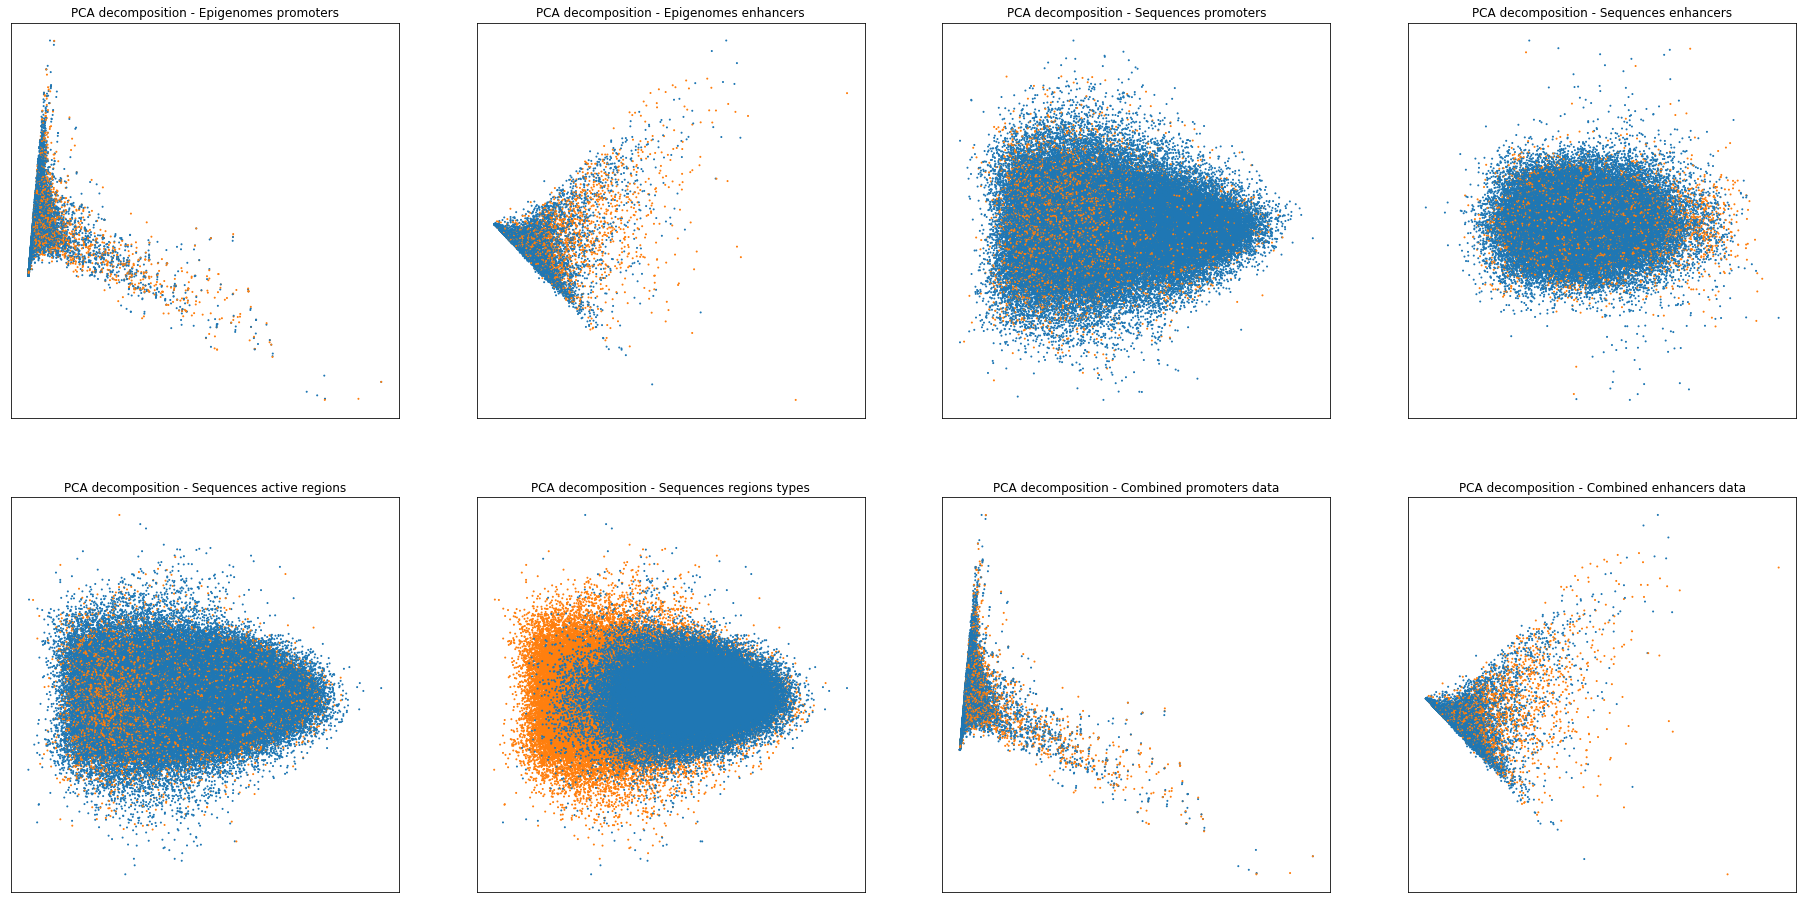

In [54]:
from sklearn.decomposition import PCA

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(32, 16))

for x, y, title, axis in tqdm(zip(xs, ys, titles, axes.flatten()), desc="Computing PCAs", total=len(xs)):
    axis.scatter(*pca(x).T, s=1, color=colors[y])
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title(f"PCA decomposition - {title}")
plt.show()

In [ ]:
for perpexity in tqdm((30, 40, 50, 100, 500, 5000), desc="Running perplexities"):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40, 20))
    for x, y, title, axis in tqdm(zip(xs, ys, titles, axes.flatten()), desc="Computing TSNEs", total=len(xs)):
        axis.scatter(*sklearn_tsne(x, perplexity=perpexity).T, s=1, color=colors[y])
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)
        axis.set_title(f"TSNE decomposition - {title}")
    fig.tight_layout()
    plt.show()